In [110]:
# Paquetes Necesarios
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple, Optional, Dict
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import argparse
import json
import time
import os
from datetime import datetime

In [ ]:
class EVL(nn.Module):
    '''
    Pérdida EVT para mínimos extremos
    '''
    def __init__(self, gamma = 1):

        super(EVL, self).__init__()

        self.gamma = gamma

    def evl_perdida_minimos(self, u: torch.Tensor, v: torch.Tensor, p_minimo: float) -> torch.Tensor:
        """Calcula la pérdida EVT para **mínimos extremos** con fórmula estable.
        Fórmula (por elemento):
        L = - β_min * (u/γ)^γ * v * log(u) - β_norm * (1 - u/γ)^γ * (1 - v) * log(1 - u)
        donde ``u`` es probabilidad en (0, 1), ``v``∈{0,1} indica mínimo, y β proviene de ``p_minimo``.
        Parameters
        ----------
        u : torch.Tensor
        Probabilidades en rango (0, 1). Si no están en (0,1), internamente se estabilizan.
        v : torch.Tensor
        Etiquetas binarias {0,1} donde 1 indica mínimo extremo.
        p_minimo : float
        Proporción (0,1) de mínimos, usada para calcular β_min = p_minimo y β_norm = 1 - p_minimo.


        Returns
        -------
        torch.Tensor
        Tensor de pérdidas **por elemento** (no reducido). Reduce fuera con ``.mean()`` o similar.
        """
        # --- Epsilons y tipos ---
        eps = 1e-6
        device = u.device

        # v a {0,1}
        v = v.float()
        # Si v no está en [0,1], asume convención {-1,0} -> {1,0}
        if v.min() < 0 or v.max() > 1:
            v = (v == -1).float()

        # p_minimo estable en (0,1)
        beta_minimo = float(p_minimo)
        beta_minimo = max(min(beta_minimo, 1.0 - eps), eps)
        beta_normal = 1.0 - beta_minimo

        # gamma > 0
        gamma = float(getattr(self, "gamma", 1.0))
        gamma = max(gamma, eps)

        # u en (0,1) para log/1-log (si u no es probabilidad, esto lo hace usable)
        # Si prefieres transformarlo con sigmoide: u = torch.sigmoid(u), comenta la línea de clamp y descomenta sigmoide.
        u = torch.nan_to_num(u, nan=0.5, posinf=1.0, neginf=0.0)
        # u = torch.sigmoid(u)  # <-- opción alternativa si tus u son scores no acotados
        u = torch.clamp(u, eps, 1.0 - eps)

        # Bases de las potencias: forzamos (0,1] para evitar negativos/ceros y explosiones
        base_min = torch.clamp(u / gamma, eps, 1.0)               # (u/γ)^γ
        base_norm = torch.clamp(1.0 - (u / gamma), eps, 1.0)       # (1 - u/γ)^γ

        # Pesos
        pesos_minimos = beta_minimo * torch.pow(base_min, gamma)
        pesos_normal  = beta_normal  * torch.pow(base_norm, gamma)

        # Términos con logs estables
        # log(u) ya es seguro por el clamp; para log(1-u) usa log1p(-u) para mejor precisión
        log_u = torch.log(u)
        log_1mu = torch.log1p(-u)  # = log(1-u)

        termino_minimo = -pesos_minimos * v        * log_u
        termino_normal = -pesos_normal  * (1.0 - v) * log_1mu

        loss_elem = termino_minimo + termino_normal
        # Sanitizar por si acaso
        loss_elem = torch.nan_to_num(loss_elem, nan=0.0, posinf=1e6, neginf=1e6)
        return loss_elem  # reduce fuera (e.g., .mean())

    def forward(self, ut: torch.Tensor, vt: torch.Tensor, p_minimo: float) -> torch.Tensor:
        vt_minimo = (vt == -1).float()  # Solo nos interesan los mínimos
        return self.evl_perdida_minimos(-ut, vt_minimo, p_minimo)  # -ut porque queremos detectar valores bajos

In [112]:
# Clase para la inicialización del Modelo

class GRU_EVT(nn.Module):

    def __init__(self, size_input, size_oculto, size_memoria, size_ventana, size_salida=1, gamma = 1, labda = 1, lr = 0.0001):

        super(GRU_EVT, self).__init__()
        
        self.size_oculto = size_oculto
        self.size_memoria = size_memoria
        self.size_ventana = size_ventana
        self.gamma = gamma
        self.lambda1 = labda
        self.taza_aprendizaje = lr
        self.umbral_ut = 0.1

        #Modelo
        self.gru = nn.GRU(size_input, size_oculto, batch_first=True)
        #Salidas
        self.capa_salida = nn.Linear(size_oculto, size_salida)
        self.extreme_predictor = nn.Sequential(
            nn.Linear(size_oculto, size_oculto//2),
            nn.ReLU(),
            nn.Linear(size_oculto//2,1),
            nn.Tanh()
        )
        #b del paper
        self.b = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        # Módulos de Memoria
        self.embedding_modulo = None #S \in R^{M X H}
        self.historia_modulo = None #Q \in {-1,0,1}^M
        #EVL
        self.evl_perdida = EVL(gamma = gamma)
        # Proporciones
        self.p_derecha = 0
        self.p_izq = 0

    def inicializar_memoria(self, device = torch.device):

        self.embedding_modulo = torch.zeros(self.size_memoria, self.size_oculto, device=device)
        self.historia_modulo = torch.zeros(self.size_memoria, dtype=torch.long, device=device)

    def actualizar_proporciones(self, vt_batch: torch.Tensor):
        vt_np = vt_batch.cpu().numpy()
        total = len(vt_np)
        self.p_minimo = np.sum(vt_np == -1) / total  # Solo mínimos

    def predecir_extremo_ventana(self, sj : torch.Tensor) -> torch.Tensor:

        return self.extreme_predictor(sj).squeeze()
    
    def computar_perdidas(self,
                      prediccion: torch.Tensor,
                      targets: torch.Tensor,
                      ut_valores: torch.Tensor,
                      vt_valores: torch.Tensor) -> Dict[str, torch.Tensor]:
        import torch.nn.functional as F
        eps = 1e-6

        # --- Sanitizar entradas ---
        prediccion = torch.nan_to_num(prediccion, nan=0.0, posinf=1e6, neginf=-1e6)
        targets    = torch.nan_to_num(targets,    nan=0.0, posinf=1e6, neginf=-1e6)
        ut_valores = torch.nan_to_num(ut_valores, nan=0.0, posinf=1e6, neginf=-1e6)
        vt_valores = torch.nan_to_num(vt_valores, nan=0.0, posinf=1e6, neginf=-1e6)

        # --- MSE ---
        mse_loss = F.mse_loss(prediccion, targets)

        # --- EVT sobre secuencia (L1) ---
        v_bin = (vt_valores == -1).float()
        tau = 2
        #tau = float(getattr(self, "tau", 1.0))
        u_prob = ut_valores
        if (u_prob.min() < 0) or (u_prob.max() > 1):
            u_prob = torch.sigmoid(-u_prob / tau)  # ← más negativo → prob(mínimo) más ALTA
        u_prob = u_prob.clamp(eps, 1 - eps)


        # ⬅️ Usa SIEMPRE la versión estable
        evl_loss_ut = self.evl_perdida.evl_perdida_minimos(u_prob, v_bin, self.p_minimo).mean()
        L1 = mse_loss + self.lambda1 * evl_loss_ut

        # --- EVT sobre memoria (L2) ---
        if (getattr(self, "embedding_modulo", None) is not None) and (getattr(self, "historia_modulo", None) is not None):
            pj_predicciones = self.predecir_extremo_ventana(self.embedding_modulo)  # logits o probs [M]
            if (pj_predicciones.min() < 0) or (pj_predicciones.max() > 1):
                pj_predicciones = torch.sigmoid(pj_predicciones)
            pj_predicciones = pj_predicciones.clamp(eps, 1.0 - eps)

            qj_target = (self.historia_modulo == -1).float()

            # ⬅️ Aquí también: NUNCA llames self.evl_perdida(...)
            evl_L2 = self.evl_perdida.evl_perdida_minimos(pj_predicciones, qj_target, self.p_minimo)
            L2 = torch.nan_to_num(evl_L2, nan=0.0, posinf=1e6, neginf=-1e6).mean()
        else:
            L2 = prediccion.new_tensor(0.0)

        perdida_total = torch.nan_to_num(L1 + L2, nan=0.0, posinf=1e6, neginf=-1e6)

        return {
            'perdida_total': perdida_total,
            'L1': L1,
            'L2': L2,
            'mse_perdida': mse_loss,
            'evl_perdida_ut': evl_loss_ut
        }


    
    def forward(self, x: torch.Tensor, tiempo_actual: int, return_components: bool = False) -> torch.Tensor:

        batch_size, sucesion_len, _ = x.shape

        # Procesamiento del GRU
        gru_out, oculto = self.gru(x)
        #ultimo_oculto = oculto[-1]  # Último estado oculto
        ultimo_oculto = oculto.squeeze(0)

        # Predicción Normal
        pred_normal = self.capa_salida(ultimo_oculto)

        # Mecanismo de Atención de Memoria
        ut = torch.zeros(batch_size, device=x.device)

        # Verificar si los módulos de memoria están inicializados
        if (hasattr(self, 'embedding_modulo') and self.embedding_modulo is not None and 
            hasattr(self, 'historia_modulo') and self.historia_modulo is not None):
            
            # Scores de atención - CORREGIDO
            score_atencion = ultimo_oculto @ self.embedding_modulo.t()  # [batch_size, memory_size]

            pesos_atencion = torch.softmax(score_atencion, dim=1)
            pesos_atencion = torch.nan_to_num(pesos_atencion, nan=0.0)

            
            # One-hot encoding de historial - CORREGIDO
            historia_one_hot = torch.zeros(self.size_memoria, 3, device=x.device)
            historia_one_hot[torch.arange(self.size_memoria), self.historia_modulo.long() + 1] = 1

            # Contribución de memoria - CORREGIDO
            contribucion_memoria = torch.matmul(
                pesos_atencion,  # [batch_size, memory_size]
                historia_one_hot  # [memory_size, 3]
            )  # [batch_size, 3]

            ut = contribucion_memoria[:, 2] - contribucion_memoria[:, 0]  # [batch_size]

        # Predicción final - CORREGIDO (multiplicación en lugar de suma)
        pred_final = pred_normal + self.b * ut.unsqueeze(1)  # [batch_size, 1]

        ut = torch.nan_to_num(ut, nan=0.0, posinf=1e6, neginf=-1e6)
            
        if return_components:
            return pred_final, pred_normal, ut

        return pred_final
    
    def get_label(self, sucesion, time_step):
        """Solo detectar mínimos extremos"""
        if time_step + 1 >= len(sucesion):
            return 0
        
        valor_actual = sucesion[time_step]
        valor_sig = sucesion[time_step+1]

        # Umbral solo para mínimos
        umbral_abajo = valor_actual - 2 * torch.std(sucesion[:time_step])

        if valor_sig < umbral_abajo:
            return -1  # Solo mínimos
        else:
            return 0   # Normal
    
    def sample_historia(self, tiempo_actual, sucesion, vt_sucesion):
        # Inicializa
        ventanas, labels = [], []

        # Si no hay suficientes pasos para formar una ventana completa, sal
        if tiempo_actual <= self.size_ventana + 1:
            return [], []

        # === NORMALIZA DEVICE ===
        device = vt_sucesion.device  # elegimos el de vt
        if sucesion.device != device:
            sucesion = sucesion.to(device)  # que 'sucesion' también esté en el mismo device

        # Índices válidos: el "final" de cada ventana (excluye el último paso)
        indices = torch.arange(self.size_ventana, tiempo_actual - 1, device=device)

        if indices.numel() == 0:
            return [], []

        # Segmento de vt y máscara de extremos EN EL MISMO DEVICE
        vt_seg = vt_sucesion[self.size_ventana:tiempo_actual - 1].to(device)
        ext_mask = (vt_seg == -1)
        # (por si acaso) asegura misma device que 'indices'
        if ext_mask.device != indices.device:
            ext_mask = ext_mask.to(indices.device)

        # Separa extremos y normales
        ext_indices  = indices[ext_mask]
        norm_indices = indices[~ext_mask]

        # Cuántas muestras quieres a memoria en este paso
        k = min(getattr(self, "size_memoria", self.size_ventana), indices.numel())

        # Toma todos los extremos y completa con normales
        sel_ext = ext_indices
        faltan = k - sel_ext.numel()
        if faltan > 0:
            if norm_indices.numel() >= faltan:
                perm = torch.randperm(norm_indices.numel(), device=device)[:faltan]
                sel_norm = norm_indices[perm]
            else:
                if norm_indices.numel() > 0:
                    rnd = torch.randint(0, norm_indices.numel(), (faltan,), device=device)
                    sel_norm = norm_indices[rnd]
                else:
                    sel_norm = torch.empty(0, dtype=indices.dtype, device=device)
            sample_id = torch.cat([sel_ext, sel_norm], dim=0)
        else:
            perm = torch.randperm(sel_ext.numel(), device=device)[:k]
            sample_id = sel_ext[perm]

        # Construye ventanas y labels
        for idx in sample_id.tolist():  # idx es int en Python
            inicio, final = idx - self.size_ventana, idx
            ventana = sucesion[inicio:final]             # mismo device que 'sucesion'
            etiqueta = int(vt_sucesion[final].item())    # etiqueta del "siguiente" instante
            etiqueta = -1 if etiqueta == -1 else 0
            ventanas.append(ventana.unsqueeze(0))        # [1, size_ventana, feat]
            labels.append(etiqueta)

        return ventanas, labels


    
    def inicializar_memoria(self, device):

        self.embedding_modulo = torch.zeros(self.size_memoria, self.size_oculto, device=device)
        self.historia_modulo = torch.zeros(self.size_memoria, dtype=torch.long, device=device)

    def actualizar_memoria(self, ventanas, labels):

        if len(ventanas) == 0:
            return
        
        with torch.no_grad():
            embeddings = []
            for ventana in ventanas:
                _, oculto = self.gru(ventana)
                emb = oculto.squeeze(0).squeeze(0)
                embeddings.append(emb)
            
            embeddings = torch.stack(embeddings, dim=0)
        
        size_memoria_nueva = embeddings.size(0)

        if self.embedding_modulo is None:
            self.inicializar_memoria(embeddings.device)
        
        self.embedding_modulo = torch.cat([
            self.embedding_modulo[size_memoria_nueva:],
            embeddings
        ], dim=0)

        labels_tensor = torch.tensor(labels, dtype=torch.long, 
                                     device=self.historia_modulo.device)
        self.historia_modulo = torch.cat([
            self.historia_modulo[size_memoria_nueva:],
            labels_tensor
        ], dim=0)

In [ ]:
class EntrenamientoEVT(nn.Module):
    def __init__(self, size_input, size_oculto, size_memoria, size_ventana, tasa_aprendizaje=0.001, gamma=1, labda1=1):
        super(EntrenamientoEVT, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = GRU_EVT(
            size_input=size_input,
            size_oculto=size_oculto,
            size_memoria=size_memoria,
            size_ventana=size_ventana,
            gamma=gamma,
            labda=labda1,
            lr = tasa_aprendizaje
        ).to(self.device)
        
        self.optimizador = optim.Adam(self.model.parameters(), lr=tasa_aprendizaje)
        self.lambda1 = labda1
        self.loss_history = {'train': [], 'val': []}
    
    def alinear_targets(self, predicciones, targets, vt_labels):
        if targets.dim() == 2:
            targets = targets.unsqueeze(-1)
        T_pred = predicciones.size(1)
        if targets.size(1) == T_pred + 1:
            targets = targets[:, 1:1+T_pred, :]
            vt_slice = vt_labels[:, 1:1+T_pred]
        else:
            targets = targets[:, :T_pred, :]
            vt_slice = vt_labels[:, :T_pred]
        return targets, vt_slice


    def entrenar_epoca(self, train_loader):
        self.model.train()
        total_loss = 0.0
        for batch_idx, (data, targets, vt_labels) in enumerate(train_loader):
            data, targets, vt_labels = data.to(self.device), targets.to(self.device), vt_labels.to(self.device)

            # Reiniciar memoria para cada batch
            self.model.inicializar_memoria(self.device)

            self.optimizador.zero_grad()
            self.model.actualizar_proporciones(vt_labels)

            batch_size, sec_len, _ = data.shape
            pred_todas, ut_val_todos = [], []

            for t in range(sec_len):
                input_actual = data[:, :t+1, :]
                if t > self.model.size_ventana:
                    ventanas, labels = self.model.sample_historia(t, data[0, :t], vt_labels[0])
                    self.model.actualizar_memoria(ventanas, labels)

                pred, normal_pred, ut = self.model(input_actual, t, return_components=True)
                pred_todas.append(pred)
                ut_val_todos.append(ut)

            predicciones = torch.stack(pred_todas, dim=1)  # [B, T_pred, 1]
            ut_valores   = torch.stack(ut_val_todos, dim=1) # [B, T_pred]

            targets, vt_slice = self.alinear_targets(predicciones, targets, vt_labels)
            perdidas = self.model.computar_perdidas(predicciones, targets, ut_valores, vt_slice)

            perdidas['perdida_total'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Sanitiza gradientes (por si algún op devuelve inf/NaN)
            for p in self.model.parameters():
                if p.grad is not None:
                    p.grad.data = torch.nan_to_num(p.grad.data, nan=0.0, posinf=1e6, neginf=-1e6)

            self.optimizador.step()

            # Sanitiza pesos tras el step
            with torch.no_grad():
                for p in self.model.parameters():
                    p.data = torch.nan_to_num(p.data, nan=0.0, posinf=1e6, neginf=-1e6)

            total_loss += float(perdidas['perdida_total'].detach().cpu())

            # (Opcional) debug cada N batches
            if getattr(self, "debug", False) and (batch_idx % 100 == 0):
                print(
                    f"evl_ut={float(perdidas['evl_perdida_ut']):.4e} "
                    f"L1={float(perdidas['L1']):.4e} L2={float(perdidas['L2']):.4e} "
                    f"total={float(perdidas['perdida_total']):.4e}")

        return total_loss / max(1, len(train_loader))


    def evaluar(self, val_loader):
        self.model.eval()
        total_loss = 0.0
        total_batches = 0
        self.last_val_f1 = float('nan')  # por si no se calcula

        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, (list, tuple)) and len(batch) == 4:
                    data, targets, ut_labels, vt_labels = batch
                elif isinstance(batch, (list, tuple)) and len(batch) == 3:
                    data, targets, vt_labels = batch  # val/test devuelven vt
                    ut_labels = vt_labels            # placeholder no usado
                else:
                    raise ValueError(f"Esperaba 3 o 4 elementos por batch, recibí {len(batch)}.")

                data, targets = data.to(self.device), targets.to(self.device)
                ut_labels, vt_labels = ut_labels.to(self.device), vt_labels.to(self.device)

                sec_len = data.size(1)
                pred_todas, ut_val_todos = [], []

                for t in range(sec_len - 1):
                    input_actual = data[:, :t+1, :]
                    if t > self.model.size_ventana:
                        ventanas, labels = self.model.sample_historia(t, data[0, :t], vt_labels[0])
                        self.model.actualizar_memoria(ventanas, labels)

                    pred, normal_pred, ut = self.model(input_actual, t, return_components=True)
                    pred_todas.append(pred)
                    ut_val_todos.append(ut)

                predicciones = torch.stack(pred_todas, dim=1)
                ut_valores   = torch.stack(ut_val_todos, dim=1)

                targets, vt_slice = self.alinear_targets(predicciones, targets, vt_labels)
                perdidas = self.model.computar_perdidas(predicciones, targets, ut_valores, vt_slice)

                total_loss += float(perdidas['perdida_total'].detach().cpu())
                total_batches += 1

                # F1 de extremos en validación
                umbral = float(getattr(self.model, "umbral_ut", getattr(self.model, "p_minimo", 0.1)))
                if umbral > 1:
                    umbral = umbral / 100.0
                pred_extremo_val = (ut_valores <= -umbral)
                true_extremo_val = (vt_slice == -1)
                from sklearn.metrics import f1_score
                y_pred_val = pred_extremo_val.detach().cpu().numpy().astype(int).ravel()
                y_true_val = true_extremo_val.detach().cpu().numpy().astype(int).ravel()
                self.last_val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)

        return total_loss / max(1, total_batches)

    def calibrar_umbral_ut(self, val_loader):
  
        self.model.eval()
        uts, vts = [], []
        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, (list, tuple)) and len(batch) == 4:
                    data, targets, ut_labels, vt_labels = batch
                else:
                    data, targets, vt_labels = batch
                data, vt_labels = data.to(self.device), vt_labels.to(self.device)

                sec_len = data.size(1)
                ut_steps = []
                for t in range(sec_len - 1):
                    inp = data[:, :t+1, :]
                    _, _, ut = self.model(inp, t, return_components=True)
                    ut_steps.append(ut)
                ut_seq = torch.stack(ut_steps, dim=1)  # [B, T]
                # Reusa tu helper de alineación para recortar vt
                _, vt_slice = self.alinear_targets(ut_seq.unsqueeze(-1), targets, vt_labels)
                uts.append(ut_seq.detach().cpu().numpy().ravel())
                vts.append((vt_slice == -1).float().cpu().numpy().ravel())

        ut_all = np.concatenate(uts)   # en [-1, 0]
        vt_all = np.concatenate(vts).astype(int)

        best_t, best_f1 = 0.10, -1.0
        for t in np.linspace(0.02, 0.6, 60):
            pred = (ut_all <= -t).astype(int)
            f1 = f1_score(vt_all, pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t

        self.model.umbral_ut = float(best_t)
        return best_t, best_f1

    def entrenar_epocas(self, train_loader, val_loader, epochs=100, paciencia=10):
        mejor_perdida_val = float('inf')
        contador_paciencia = 0
        
        for epoch in range(epochs):
            # Entrenamiento
            train_loss = self.entrenar_epoca(train_loader)
            self.loss_history['train'].append(train_loss)
            
            # Validación
            val_loss = self.evaluar(val_loader)
            self.loss_history['val'].append(val_loss)
            
            # Early stopping
            if val_loss < mejor_perdida_val:
                mejor_perdida_val = val_loss
                contador_paciencia = 0
                # Guardar mejor modelo
                torch.save(self.model.state_dict(), 'mejor_modelo.pth')
            else:
                contador_paciencia += 1
                if contador_paciencia >= paciencia:
                    print(f"Early stopping en época {epoch}")
                    break
            
            # Logging
            if epoch % 10 == 0 or epoch == epochs - 1:
                f1_txt = f" | Val F1(ext): {getattr(self, 'last_val_f1', float('nan')):.3f}"
                print(f"Época {epoch:3d} | Train Loss: {train_loss:.6e} | Val Loss: {val_loss:.6e}{f1_txt} | Paciencia: {contador_paciencia}/{paciencia}")

        
        # Cargar mejor modelo
        state = torch.load('mejor_modelo.pth', map_location=self.device)
        self.model.load_state_dict(state)

        # Calibrar umbral con validación (opcional pero recomendado)
        try:
            umbral, f1 = self.calibrar_umbral_ut(val_loader)
        except Exception as e:
        
        return self.loss_history

In [114]:
class Data:

    def __init__(self, ruta, target, suc_long):

        self.ruta = ruta
        self.target = target
        self.suc_long = suc_long
        self.scaler_x = StandardScaler()
        self.scaler_y = StandardScaler()
        self.feature = None
        self.verbose = False

    def cargar_datos(self):

        df = pd.read_csv(self.ruta, index_col=0)
        self.feature = [col for col in df.columns if col != self.target]
        X = df[self.feature].values.astype(np.float32)
        y = df[self.target].values.astype(np.float32).reshape(-1,1)

        X_scaled = self.scaler_x.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y)

        return X_scaled, y_scaled, df
    
    def detectar_extremos(self, y_sucesion, metodo) -> np.ndarray:
        # Prueba con un método adaptativo para series temporales
        y_flat = y_sucesion.flatten()
        vt = np.zeros(len(y_flat))
        
        # Usar percentiles más extremos para detectar outliers
        if metodo == 'percentil':

            lower_threshold = np.percentile(y_flat, 15) 
            vt[y_flat < lower_threshold] = -1

        else:

            mean_val = np.mean(y_flat)
            std_val = np.std(y_flat)
            lower_threshold = mean_val - 1.5 * std_val
            
            vt[y_flat < lower_threshold] = -1 

        if self.verbose:
            print(f"Mínimos extremos detectados: {np.sum(vt == -1)}/{len(vt)} ({(np.sum(vt == -1)/len(vt))*100:.1f}%)")
        return vt

    
    def crear_sucesiones(self, X, y, metodo):

        n = len(X) - self.suc_long
        X_sucesion = []
        y_sucesion = []
        vt_sucesion = []

        for i in range(n):
            X_suc = X[i:i+self.suc_long]
            y_suc = y[i+1:i+self.suc_long+1]
            vt_suc = self.detectar_extremos(y_suc, metodo=metodo)
            X_sucesion.append(X_suc)
            y_sucesion.append(y_suc)
            vt_sucesion.append(vt_suc)
        
        return np.array(X_sucesion), np.array(y_sucesion), np.array(vt_sucesion)
    
    def procesar_datos(self, metodo, test_size = 0.2, val_size = 0.1):

        X, y, df = self.cargar_datos()
        X_suc, y_suc, vt_suc = self.crear_sucesiones(X,y, metodo)
        X_train, X_test, y_train, y_test, vt_train, vt_test = train_test_split(
            X_suc, y_suc, vt_suc, test_size=test_size, random_state=42, shuffle=False
        )
    
        X_train, X_val, y_train, y_val, vt_train, vt_val = train_test_split(
            X_train, y_train, vt_train, test_size=val_size, random_state=42, shuffle=False
        )

        return (X_train, y_train, vt_train), (X_val, y_val, vt_val), (X_test, y_test, vt_test)

In [115]:
def load_config():
    default_config = {
        "excel_path": r'C:\Users\andre\OneDrive\Documentos\II2025\Asistencia CIMPA\Cuencas\ValoresExtremos\data\Brujo\BaseCompletaFecha.csv',
        "target_column": "caudal_minimo",
        "input_size": 68,
        "hidden_size": 64,
        "memory_size": 30,
        "window_size": 10,
        "seq_length": 30,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "gamma": 1,
        "lambda1": 2
    }
    
    if os.path.exists('config.json'):
        with open('config.json', 'r') as f:
            loaded_config = json.load(f)
            default_config.update(loaded_config)
    
    return default_config

In [ ]:
def inicializar():
    config = load_config()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    cargar_datos = Data(
        ruta=config['excel_path'],
        target=config['target_column'],
        suc_long=config['seq_length']
    )
    
    entrenador = EntrenamientoEVT(
        size_input=config['input_size'],
        size_oculto=config['hidden_size'],
        size_memoria=config['memory_size'],
        size_ventana=config['window_size'],
        tasa_aprendizaje=config['learning_rate'],
        gamma=config['gamma'],
        labda1=config['lambda1']
    ).to(device)
    
    return config, device, cargar_datos, entrenador

def dataloaders(cargar_datos, batch_size, metodo):

    (X_train, y_train, vt_train), (X_val, y_val, vt_val), (X_test, y_test, vt_test) = cargar_datos.procesar_datos(metodo)
    
    train_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_train),
            torch.FloatTensor(y_train),
            torch.FloatTensor(vt_train)
        ),
        batch_size=batch_size,
        shuffle=True
    )
    
    val_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_val),
            torch.FloatTensor(y_val),
            torch.FloatTensor(vt_val)
        ),
        batch_size=batch_size,
        shuffle=False
    )
    
    test_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_test),
            torch.FloatTensor(y_test),
            torch.FloatTensor(vt_test)
        ),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader

def evaluar_modelo(entrenador, dataloader, device, dataset_name="Caudal_Minimo"):

    entrenador.model.eval()
    all_predictions = []
    all_targets = []
    all_ut = []
    all_vt = []
    
    with torch.no_grad():
        for data, targets, vt_labels in dataloader:
            data, targets, vt_labels = data.to(device), targets.to(device), vt_labels.to(device)
            
            entrenador.model.inicializar_memoria(device)

            predictions = []
            ut_values = []
            
            for t in range(data.size(1)):
                current_input = data[:, :t+1, :]

                if t > entrenador.model.size_ventana:
                    ventanas, labels = entrenador.model.sample_historia(t, data[0, :t], vt_labels[0])
                    entrenador.model.actualizar_memoria(ventanas, labels)

                    
                pred_final, pred_normal, ut = entrenador.model(current_input, t, return_components=True)
                predictions.append(pred_final)
                ut_values.append(ut)
            
            predictions = torch.stack(predictions, dim=1)  # [B, T, 1]
            ut_values   = torch.stack(ut_values, dim=1)
            
            all_predictions.append(predictions.cpu())
            all_targets.append(targets.cpu())
            all_ut.append(ut_values.cpu())
            all_vt.append(vt_labels.cpu())
    
    all_predictions = torch.cat(all_predictions).numpy().reshape(-1)
    all_targets = torch.cat(all_targets).numpy().reshape(-1)
    all_ut = torch.cat(all_ut).numpy()
    all_vt = torch.cat(all_vt).numpy()
    
    return all_predictions, all_targets, all_ut, all_vt

def calcular_metricas(predictions, targets, ut, vt, dataset_name, p_minimo):
    print(f"UT : min={ut.min():.3f}, max={ut.max():.3f}, mean={ut.mean():.3f}, std={ut.std():.3f}")
    print(f"UT valores: {np.unique(ut.round(2), return_counts=True)}")
    print(f"VT : {np.unique(vt, return_counts=True)}")

    # --- UMBRAL CORRECTO: más extremo = más negativo ---
    umbral = float(p_minimo)
    if umbral > 1:
        umbral = umbral / 100.0
    ut_extreme_mask = (ut <= -umbral)
    print(f"UT <= -{umbral:.3f}: {np.sum(ut_extreme_mask)} samples")
    print(f"VT= {vt[ut_extreme_mask]}")

    predictions = predictions.flatten()
    targets = targets.flatten()
    ut = ut.flatten()
    vt = vt.flatten()

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)

    extreme_mask = (vt == -1)
    if extreme_mask.any():
        extreme_mse = mean_squared_error(targets[extreme_mask], predictions[extreme_mask])
        extreme_mae = mean_absolute_error(targets[extreme_mask], predictions[extreme_mask])
    else:
        extreme_mse = extreme_mae = 0.0

    # Predicción binaria de extremos basada en UT y p_minimo
    predicted_extremes = (ut <= -umbral).astype(int)
    true_extremes = (vt == -1).astype(int)

    if np.any(true_extremes):
        precision = precision_score(true_extremes, predicted_extremes, zero_division=0)
        recall    = recall_score(true_extremes, predicted_extremes, zero_division=0)
        f1        = f1_score(true_extremes, predicted_extremes, zero_division=0)
        cm        = confusion_matrix(true_extremes, predicted_extremes).tolist()
    else:
        precision = recall = f1 = 0.0
        cm = [[0, 0], [0, 0]]

    metrics = {
        f'{dataset_name}_mse': float(mse),
        f'{dataset_name}_mae': float(mae),
        f'{dataset_name}_rmse': float(rmse),
        f'{dataset_name}_r2': float(r2),
        f'{dataset_name}_extreme_mse': float(extreme_mse),
        f'{dataset_name}_extreme_mae': float(extreme_mae),
        f'{dataset_name}_extreme_ratio': float(np.mean(extreme_mask)),
        f'{dataset_name}_precision': float(precision),
        f'{dataset_name}_recall': float(recall),
        f'{dataset_name}_f1': float(f1),
        f'{dataset_name}_confusion_matrix': cm
    }

    print(f"Eventos Extremos : {np.sum(vt != 0)}")
    print(f"Proporción: {np.mean(vt != 0):.4f}")

    print(f"\MÉTRICAS {dataset_name.upper()}:")
    for k, v in metrics.items():
        if 'confusion_matrix' not in k:
            print(f"   {k}: {v:.6f}")

    return metrics

In [ ]:

# Código principal de ejecución
config, device, cargar_datos, entrenador = inicializar()
entrenador.debug = True  # después de inicializar

train_loader, val_loader, test_loader = dataloaders(cargar_datos, config['batch_size'], 'percentil')

print("Epocas")
loss_history = entrenador.entrenar_epocas(train_loader, val_loader, epochs=1000, paciencia=150)

print("Evaluando")
predictions, targets, ut, vt = evaluar_modelo(entrenador, test_loader, device, "Test")
umbral_test = getattr(entrenador.model, "umbral_ut", getattr(entrenador.model, "p_minimo", 0.1))
umbral = float(getattr(entrenador.model, "umbral_ut", entrenador.model.p_minimo))
metrics = calcular_metricas(predictions, targets, ut, vt, "Test", umbral)

print("Gráfico de Pérdidas")
plot_losses(loss_history)

In [ ]:
metrics = calcular_metricas(predictions, targets, ut, vt, "Test", umbral)


🔍 DEBUG Test:
UT stats: min=-0.995, max=0.000, mean=-0.038, std=0.111
UT values: (array([-1.  , -0.99, -0.54, -0.49, -0.48, -0.41, -0.39, -0.37, -0.35,
       -0.34, -0.31, -0.29, -0.28, -0.26, -0.25, -0.24, -0.23, -0.22,
       -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  2,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   3,
         2,   2,   1,   1,   3,   4,   6,   2,   5,   2,   3,   3,   4,
         2,   5,   9,   4,   8,   2,  10,   8,  11,  11,  26,  28,  47,
       403]))
VT distribution: (array([-1.,  0.], dtype=float32), array([ 99, 531]))
UT <= -0.040: 119 samples
Corresponding VT for these: [ 0.  0.  0.  0. -1. -1.  0.  0.  0.  0.  0. -1. -1.  0.  0.  0. -1. -1.
 -1. -1. -1.  0. -1. -1.  0. -1. -1.  0. -1. -1.  0. -1. -1. -1.  0.  0.
  0. -1.  0. -1. -1.  0. -1. -1.  0.  0. -1. -1.  0.  0. -1. -1.  0.  0.
 -1. -1.  0

Gráficos individuales


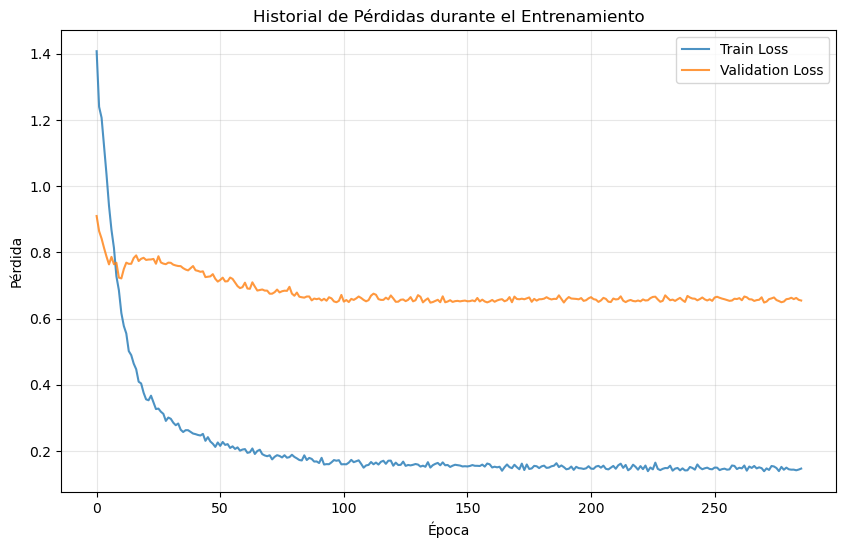

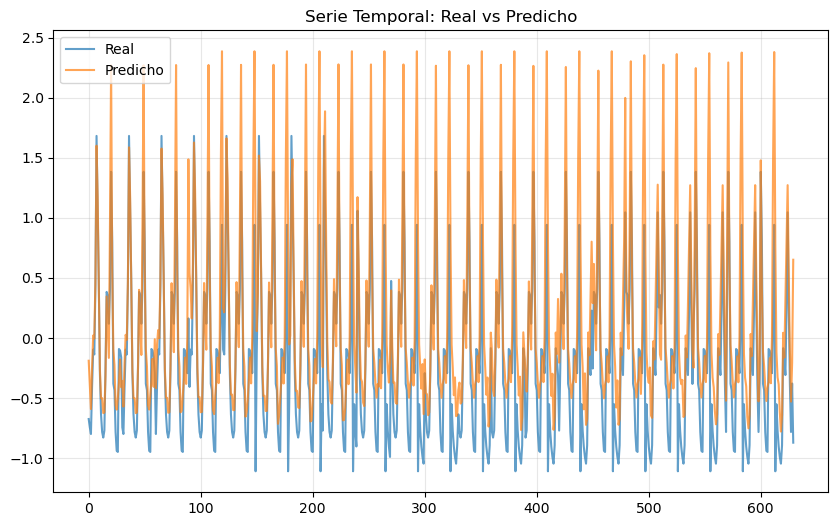

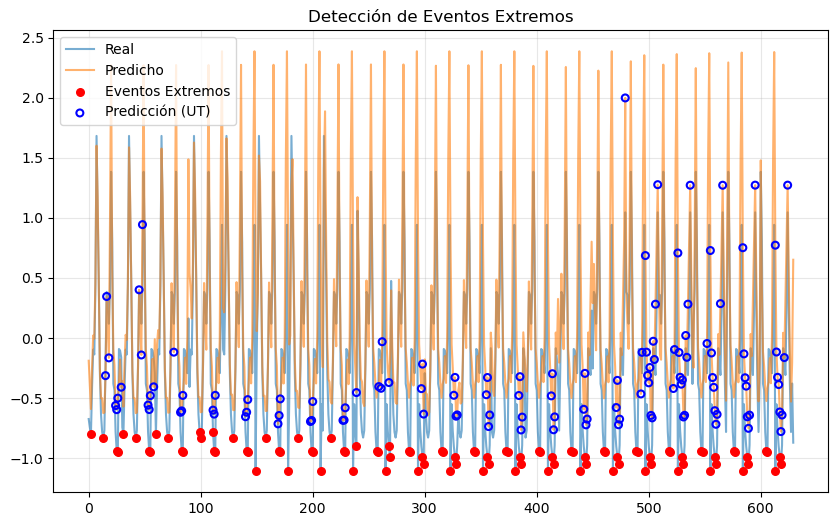

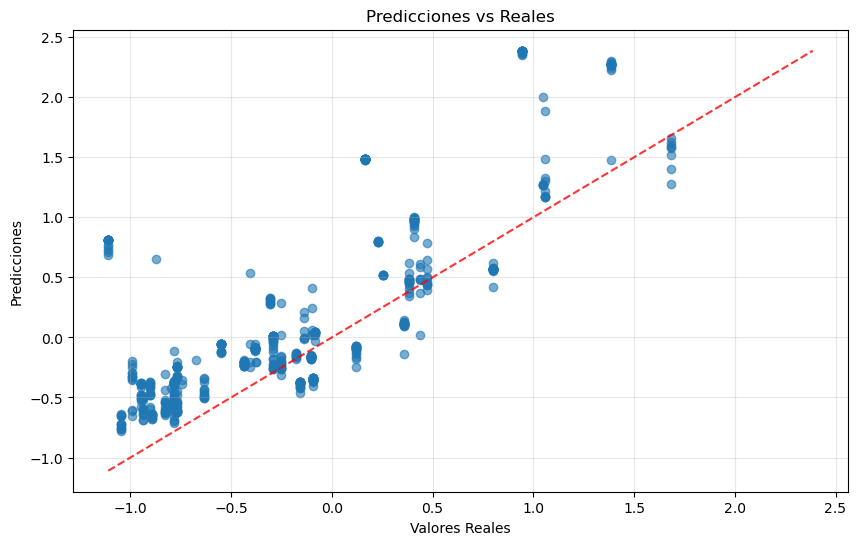

In [123]:
print("Gráficos individuales")

# (Opcional) evita superposiciones si re-ejecutas la celda
plt.close('all')

plt.figure(figsize=(10, 6))
plt.plot(loss_history['train'], label='Train Loss', alpha=0.8)
plt.plot(loss_history['val'], label='Validation Loss', alpha=0.8)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas durante el Entrenamiento')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ========= 1) Serie Temporal: Real vs Predicho =========
plt.figure(num="Serie Temporal: Real vs Predicho", figsize=(10, 6))
plt.plot(targets, label='Real', alpha=0.7)
plt.plot(predictions, label='Predicho', alpha=0.7)
plt.title('Serie Temporal: Real vs Predicho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ========= 2) Detección de Eventos Extremos =========
plt.figure(num="Detección de Eventos Extremos", figsize=(10, 6))

# Asegura 1D numpy
pred = np.ravel(predictions)
real = np.ravel(targets)
ut_arr = np.ravel(ut)   # cambia si tu variable se llama distinto
vt_arr = np.ravel(vt)

# Alinea longitudes (pred suele ser T_pred = sec_len-1)
T = len(pred)
real = real[-T:]
vt_plot = vt_arr[1:1+T] if len(vt_arr) >= T+1 else vt_arr[-T:]
x = np.arange(T)

# Mínimos reales
true_mask = (vt_plot == -1)
plt.plot(x, real, alpha=0.6, label='Real')
plt.plot(x, pred, alpha=0.6, label='Predicho')
plt.scatter(x[true_mask], real[true_mask], c='red', s=30,
            label='Eventos Extremos', zorder=5)

# Mínimos predichos con UT (círculos azules)
umbral = float(getattr(entrenador.model, "umbral_ut",
                       getattr(entrenador.model, "p_minimo", 0.1)))
if umbral > 1:
    umbral /= 100.0
pred_mask = (ut_arr[-T:] <= -umbral)
plt.scatter(x[pred_mask], pred[pred_mask], s=25, facecolors='none',
            edgecolors='blue', linewidths=1.5, label='Predicción (UT)', zorder=6)

plt.title('Detección de Eventos Extremos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ========= 3) Predicciones vs Reales =========
plt.figure(num="Predicciones vs Reales", figsize=(10, 6))
plt.scatter(targets, predictions, alpha=0.6)
min_val = min(np.min(targets), np.min(predictions))
max_val = max(np.max(targets), np.max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Reales')
plt.grid(True, alpha=0.3)
plt.show()
